In [1]:
%load_ext autoreload
%autoreload 2

# Dataset preparing

In [2]:
from dataset.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd

In [3]:
true_dist_size = 1000
dataset = FactDatasetGenerator(number_person=100,  distribution="zipf", dataset_folder='./dataset/data/', food_list_name="food_list_small.txt",true_dist_size=true_dist_size)

In [4]:
# Generate all possible facts
temp = dataset.generate_all_possibilities()

In [5]:
len(temp)

10100

In [6]:
# Sample true dist (zipf)
true_dist = dataset.generate_true_dist()

In [7]:
true_dist_df = pd.DataFrame(true_dist,columns=["facts"])

In [8]:
true_dist_df

,facts
0,"Bendite,beef tartare"
1,"El,carrot cake"
2,"Shaina,gyoza"
3,"Rossy,samosa"
4,"Shaun,club sandwich"
...,...
995,"Flore,pad thai"
996,"Violetta,club sandwich"
997,"Mirilla,donuts"
998,"Farly,ravioli"


In [9]:
true_duplicates_count = true_dist_df.groupby(list(true_dist_df.columns)).size().reset_index(name='count')


In [10]:
true_duplicates_count

,facts,count
0,"Albertine,apple pie",1
1,"Albertine,beef tartare",1
2,"Albertine,french fries",1
3,"Albertine,ice cream",1
4,"Albertine,spaghetti carbonara",1
...,...,...
507,"Winfield,tiramisu",1
508,"Xenos,baklava",1
509,"Xenos,french toast",3
510,"Zeb,cheese plate",1


In [19]:
# Sample training data uniformly, %80 of true dist
train_data_size = int(0.8 * 1000)
training_data = dataset.sample_training_data(train_data_size,true_dist.tolist())

In [20]:
training_dist_df = pd.DataFrame(training_data,columns=["facts"])
training_duplicates_count = training_dist_df.groupby(list(training_dist_df.columns)).size().reset_index(name='count')

In [21]:
training_duplicates_count

,facts,count
0,"Albertine,french fries",1
1,"Albertine,ice cream",1
2,"Albertine,spaghetti carbonara",1
3,"Archibald,omelette",2
4,"Archibald,pizza",1
...,...,...
418,"Winfield,seaweed salad",1
419,"Winfield,tiramisu",1
420,"Xenos,baklava",1
421,"Xenos,french toast",3


In [22]:
import torch
## get the training  datasets
train_dataset = [torch.tensor(x, dtype=torch.long) for x in dataset.tokenized_training_data]


In [23]:
from torch.utils.data import Dataset

## create a dataset class
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming each item in data is a sequence and we use the same sequence shifted by one as the target
        x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
        y = torch.tensor(self.data[idx][1:], dtype=torch.long)
        #print(x)
        #print(y)
        
        return x, y


## create the datasets
train_data = MyDataset(train_dataset)
# test_data = MyDataset(test_dataset)

print(train_data)

# Model preparing

In [24]:
## import mingpt
sys.path.append('minGPT/')
from mingpt.model import GPT
from mingpt.utils import set_seed
set_seed(42)

model_config = GPT.get_default_config()
model_config.n_layer=12
model_config.n_head=8
model_config.n_embd=512
model_config.vocab_size = dataset.vocab_size
model_config.model_type = None
model_config.block_size = 2
model = GPT(model_config)

number of parameters: 37.93M


In [25]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 20000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_data)

running on device cuda


# Training the model

In [26]:
def batch_end_callback(trainer):
    if trainer.iter_num % 1000 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

C:\Users\Batu\AppData\Local\Temp\ipykernel_84948\4291040295.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.data[idx][:-1], dtype=torch.long)
C:\Users\Batu\AppData\Local\Temp\ipykernel_84948\4291040295.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.data[idx][1:], dtype=torch.long)


iter_dt 0.00ms; iter 0: train loss 5.39667
iter_dt 25.00ms; iter 1000: train loss 2.82567
iter_dt 25.50ms; iter 2000: train loss 2.64348
iter_dt 25.51ms; iter 3000: train loss 2.77323
iter_dt 26.00ms; iter 4000: train loss 2.68330
iter_dt 26.50ms; iter 5000: train loss 2.66579
iter_dt 26.01ms; iter 6000: train loss 2.73771
iter_dt 27.50ms; iter 7000: train loss 2.46910
iter_dt 28.51ms; iter 8000: train loss 2.51210
iter_dt 26.00ms; iter 9000: train loss 2.56047
iter_dt 28.01ms; iter 10000: train loss 2.67438
iter_dt 31.51ms; iter 11000: train loss 2.46100
iter_dt 25.51ms; iter 12000: train loss 2.58563
iter_dt 25.51ms; iter 13000: train loss 2.48247
iter_dt 29.01ms; iter 14000: train loss 2.53139
iter_dt 27.51ms; iter 15000: train loss 2.55262
iter_dt 31.50ms; iter 16000: train loss 2.68836
iter_dt 26.51ms; iter 17000: train loss 2.71920
iter_dt 28.00ms; iter 18000: train loss 2.51510
iter_dt 25.00ms; iter 19000: train loss 2.55659


In [27]:
# now let's perform some evaluation
model.eval()


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(201, 512)
    (wpe): Embedding(2, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=512, out_features=1536, bias=True)
          (c_proj): Linear(in_features=512, out_features=512, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_features=2048, out_features=512, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_fe

# Generate unconditioned facts

In [28]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [29]:
n_sequences = 1000
from collections import defaultdict
collected_generations = []

for _ in range(n_sequences):
    x = torch.Tensor([0]).unsqueeze(0).long().to("cuda")
    y_gen = model.generate(x, 2, do_sample=True)
    name = food_item = dataset.decode([y_gen[0][1]])[0]
    food_item = dataset.decode([y_gen[0][2]])[0]
    collected_generations.append(f"{name},{food_item}")

In [30]:
collected_generations_df = pd.DataFrame(collected_generations, columns=["facts"])

In [31]:
comparison_df = collected_generations_df.groupby(list(collected_generations_df.columns)).size().reset_index(name='count_generated')


In [32]:
comparison_df

,facts,count_generated
0,"Albertine,french fries",1
1,"Albertine,ice cream",2
2,"Albertine,spaghetti carbonara",4
3,"Archibald,omelette",4
4,"Archibald,pizza",3
...,...,...
335,"pho ,baby back ribs",1
336,"ramen ,garlic bread",1
337,"ravioli ,garlic bread",1
338,"tacos ,macaroni and cheese",1


In [33]:
# Merge true dist and training dist dataframes, outer is used to include data that is not in training data as well
merged_df = pd.merge(true_duplicates_count, training_duplicates_count, on='facts', how='outer',suffixes=("_true","_train"))

In [34]:
# Add generated_df to true and training dfs 
# outer can be used to include all facts in true dist
# inner can be used to only show the comparison of generated facts
comparison_df = pd.merge(merged_df, comparison_df, on='facts', how='outer')

In [35]:
comparison_df

,facts,count_true,count_train,count_generated
0,"Albertine,apple pie",1.0,NaN,NaN
1,"Albertine,beef tartare",1.0,NaN,NaN
2,"Albertine,french fries",1.0,1.0,1.0
3,"Albertine,ice cream",1.0,1.0,2.0
4,"Albertine,spaghetti carbonara",1.0,1.0,4.0
...,...,...,...,...
542,"pho ,baby back ribs",NaN,NaN,1.0
543,"ramen ,garlic bread",NaN,NaN,1.0
544,"ravioli ,garlic bread",NaN,NaN,1.0
545,"tacos ,macaroni and cheese",NaN,NaN,1.0


In [36]:
# Fill in 0 for facts that not appear
comparison_df = comparison_df.fillna(0)

In [37]:
# Normalize the counts by length
comparison_df["count_generated"] = comparison_df['count_generated']/len(collected_generations)
comparison_df["count_train"] = comparison_df['count_train']/len(training_data)
comparison_df["count_true"] = comparison_df['count_true']/true_dist_size


In [38]:
comparison_df

,facts,count_true,count_train,count_generated
0,"Albertine,apple pie",0.001,0.00000,0.000
1,"Albertine,beef tartare",0.001,0.00000,0.000
2,"Albertine,french fries",0.001,0.00125,0.001
3,"Albertine,ice cream",0.001,0.00125,0.002
4,"Albertine,spaghetti carbonara",0.001,0.00125,0.004
...,...,...,...,...
542,"pho ,baby back ribs",0.000,0.00000,0.001
543,"ramen ,garlic bread",0.000,0.00000,0.001
544,"ravioli ,garlic bread",0.000,0.00000,0.001
545,"tacos ,macaroni and cheese",0.000,0.00000,0.001


<Axes: >

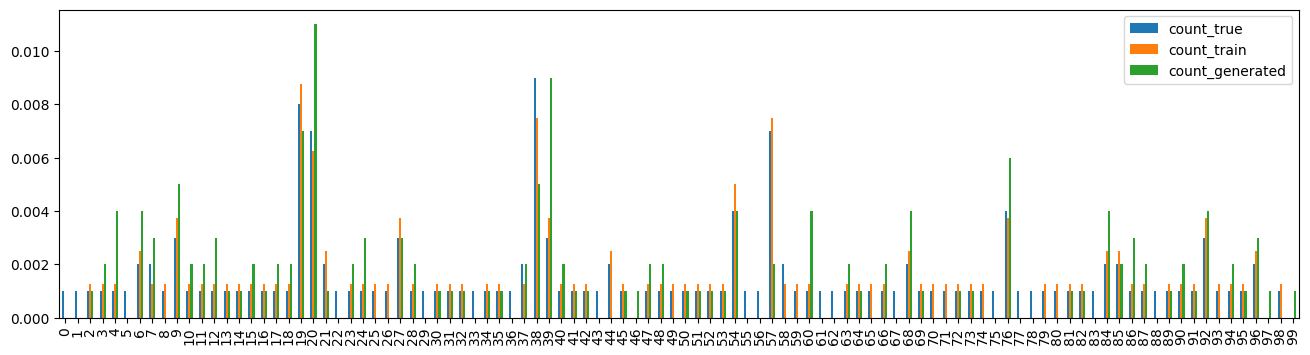

In [39]:
import matplotlib.pyplot as plt
import numpy as np
# Only the top 100 facts graphed for visibility 
comparison_df[:100].plot.bar(figsize=(16, 4))